# Algoritmo de grover


#### Autor: Fernando Ares Robledo
#### email: fernandoaresrobledo@gmail.com


#### Ultima fecha de modificacion: 28 de abril de 2023


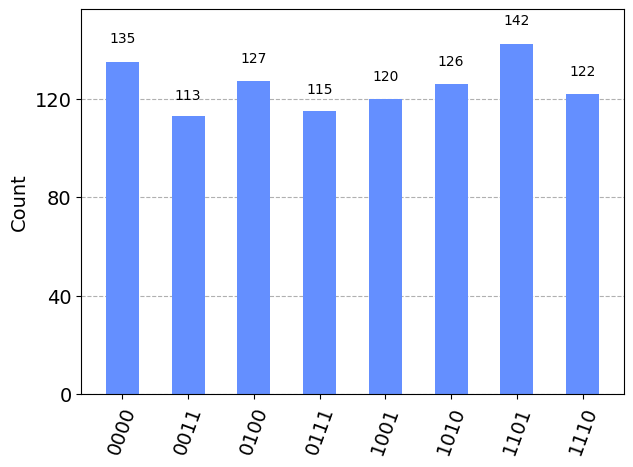

1011.1010 = 0 (mod 2) (12.3%)
1011.1001 = 0 (mod 2) (11.7%)
1011.0111 = 0 (mod 2) (11.2%)
1011.0011 = 0 (mod 2) (11.0%)
1011.0000 = 0 (mod 2) (13.2%)
1011.1110 = 0 (mod 2) (11.9%)
1011.1101 = 0 (mod 2) (13.9%)
1011.0100 = 0 (mod 2) (12.4%)


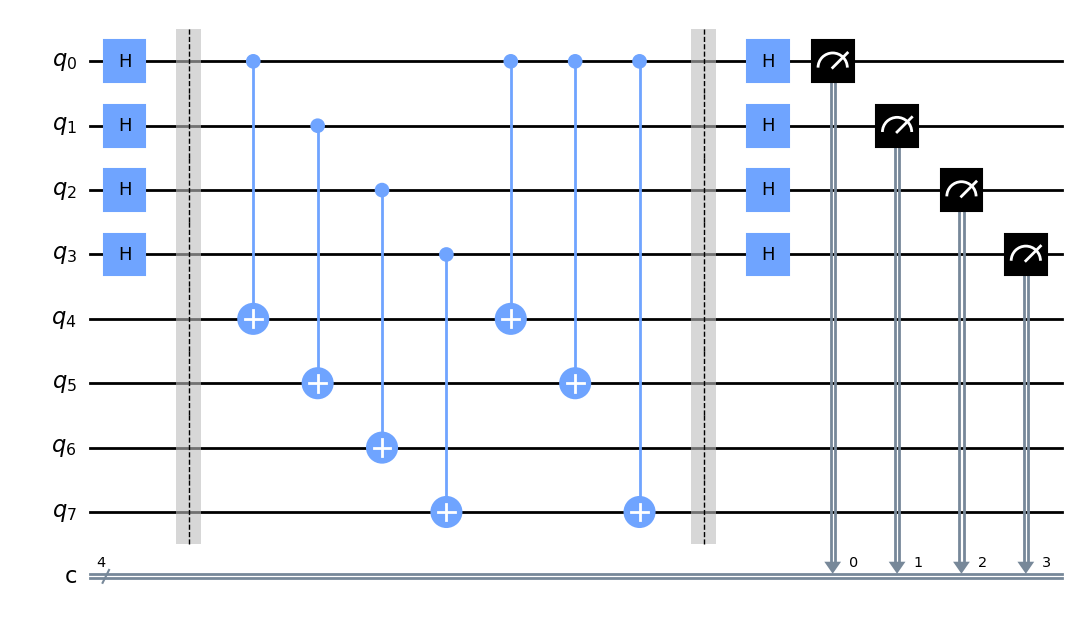

El string secreto 's' es: 1011


In [1]:
# -*- coding: utf-8 -*-

"""
Nombre del archivo: simon.ipynb

Descripción: Este script implementa el algoritmo de Simon, un algoritmo cuántico que resuelve el
problema de Simon. Dado un oráculo desconocido con una clave secreta, 
el algoritmo busca la clave secreta 's' utilizando un circuito cuántico y procesamiento clásico 
posterior. El script utiliza la biblioteca Qiskit para construir y simular el circuito cuántico, y
Sympy para realizar cálculos matriciales en el procesamiento post-clásico.


Autor: Fernando Ares Robledo
Fecha de creación: 13/02/2023
"""

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from sympy import Matrix
class AlgoritmoSimon:
    def __init__(self, b):
        """
        Constructor de la clase AlgoritmoSimon.

        Parámetros:
            b (str): String de entrada del problema de Simon, es decir, la clave secreta de un oráculo desconocido.

        Atributos de instancia:
            b (str): String de entrada del problema de Simon.
            n (int): Longitud del string de entrada.
        """
        self.b = b
        self.n = len(b)

    def oraculo_simon(self):
        """
        Construye el oráculo para el algoritmo de Simon.

        Return:
            oraculo (QuantumCircuit): Circuito cuántico que representa el oráculo de Simon.
        """

        # Crea un circuito cuántico con 2n qubits
        oraculo = QuantumCircuit(self.n * 2)

        # Aplica una compuerta CX entre cada qubit de la primera mitad del circuito y el qubit correspondiente en la segunda mitad
        [oraculo.cx(i, i + self.n) for i in range(self.n)]

        # Busca el índice del primer bit 1 en b comenzando desde la derecha
        pos_primer_bit = 0
        pos_primer_bit = next((i for i, bit in enumerate(self.b[::-1]) if bit == '1'), None)

        # Si se encuentra un bit 1, aplica una compuerta CX entre el qubit correspondiente en la primera mitad del circuito y los qubits correspondientes en la segunda mitad
        if pos_primer_bit is not None:
            m_values = [self.n + j for j, bit in enumerate(self.b[::-1]) if bit == '1']
            [oraculo.cx(pos_primer_bit, m) for m in m_values]

        return oraculo


    def construir_circuito(self):
        """
        Construye el circuito cuántico completo para el algoritmo de Simon.

        Retuen:
            circuito (QuantumCircuit): Circuito cuántico completo para el algoritmo de Simon.
        """

        # Crea un circuito cuántico con 2n qubits y n qubits clásicos
        circuito = QuantumCircuit(self.n * 2, self.n)

        # Aplica una compuerta Hadamard a cada qubit de la primera mitad del circuito
        circuito.h(range(self.n))

        # Agrega una barrera en el circuito
        circuito.barrier()

        # Comprime el circuito con el oráculo de Simon
        circuito.compose(self.oraculo_simon(), inplace=True)

        # Agrega otra barrera en el circuito
        circuito.barrier()

        # Aplica una compuerta Hadamard a cada qubit de la primera mitad del circuito nuevamente
        circuito.h(range(self.n))

        # Mide cada qubit de la primera mitad del circuito en su respectivo qubit clásico
        circuito.measure(range(self.n), range(self.n))

        return circuito


    def ejecutar_simulacion(self, shots=1000):
        """
        Ejecuta una simulación del circuito cuántico completo para el algoritmo de Simon utilizando el simulador de Qiskit.

        Parámetros:
            shots (int): El número de veces que se repite la simulación. El valor por defecto es 1000.

        Return:
            conteos (dict): Un diccionario que contiene los resultados de las mediciones en la simulación.
        """

        # Construye el circuito cuántico completo
        circuito = self.construir_circuito()

        # Define el backend como el simulador de Qiskit
        backend = Aer.get_backend('qasm_simulator')

        # Ejecuta la simulación del circuito y almacena los resultados en 'resultados'
        qobj = execute(circuito, backend, shots=shots)
        resultados = qobj.result()

        # Extrae los conteos de las mediciones
        conteos = resultados.get_counts()

        return conteos


    def producto_escalar_binario(self, z):
        """
        Calcula el producto escalar módulo 2 entre la clave secreta 'b' y una cadena binaria 'z'.

        Parámetros:
            z (str): Cadena binaria con la que se calcula el producto escalar.

        Retrun:
            producto_escalar (int): El producto escalar módulo 2 entre 'b' y 'z'.
        """

        # Multiplica cada elemento de 'b' y 'z' y suma los productos escalares resultantes
        producto_escalar = sum([int(x)*int(y) for x,y in zip(self.b, z)])

        # Calcula el producto escalar módulo 2
        return (producto_escalar % 2)


    def revisar_resultados(self, conteos, shots):
        """
        Imprime los resultados de la simulación del algoritmo de Simon en la consola.

        Parámetros:
            conteos (dict): Un diccionario que contiene los resultados de las mediciones en la simulación.
            shots (int): El número de veces que se repitió la simulación.
        """

        # Itera sobre los elementos del diccionario de conteos para obtener cada posible medición 'z' y su correspondiente conteo
        for z in conteos:
            # Imprime cada resultado de la simulación en la consola en un formato entendible para el usuario
            print('{}.{} = {} (mod 2) ({:.1f}%)'.format(self.b, z, self.producto_escalar_binario(z), conteos[z] * 100 / shots))

    def dibujar_circuito(self):
        """
        Dibuja el circuito cuántico completo del algoritmo de Simon utilizando "mpl", se puede cambiar por "txt" o "latex".
        """

        # Construye el circuito cuántico completo
        circuito = self.construir_circuito()

        # Genera una representación gráfica del circuito utilizando la opción 'mpl'
        figura = circuito.draw(output='mpl')

        # Muestra la figura en la consola
        return display(figura)


    def histograma(self, conteos):
        """
        Genera un histograma a partir de los conteos de las mediciones obtenidos en la simulación del algoritmo de Simon.

        Parámetros:
            conteos (dict): Un diccionario que contiene los resultados de las mediciones en la simulación.
        """

        # Genera un histograma a partir del diccionario de conteos utilizando la función 'plot_histogram' de la biblioteca 'qiskit.visualization'
        histograma = plot_histogram(conteos)

        # Muestra el histograma en la consola utilizando la función 'display'
        return display(histograma)

    
    def procesamiento_post_clasico(self, conteos):
        """
        Realiza el procesamiento post-clásico del algoritmo de Simon para encontrar la clave secreta.

        Parámetros:
            conteos (dict): Un diccionario que contiene los resultados de las mediciones en la simulación.

        Return:
            clave_secreta_matriz_mod2 (Matrix): Una matriz binaria que representa la forma escalonada reducida por filas de los resultados filtrados de las mediciones.
        """

        # Filtra las mediciones que son cero
        conteos_filtrados = [medicion for medicion in conteos if medicion != "0" * self.n]

        # Crea una matriz binaria con los resultados filtrados
        matriz = Matrix([list(map(int, medicion)) for medicion in conteos_filtrados])

        # Calcula la forma escalonada reducida por filas de la matriz binaria utilizando el método 'rref' de la biblioteca 'sympy' 
        matriz_escalonada_filas = matriz.rref(pivots=False, iszerofunc=lambda x: x % 2 == 0)

        # Convierte todos los elementos de la matriz escalonada reducida a valores módulo 2 utilizando el método 'applyfunc'
        clave_secreta_matriz_mod2 = matriz_escalonada_filas.applyfunc(lambda x: x % 2)

        return clave_secreta_matriz_mod2

    def encontrar_clave_secreta(self, clave_secreta_matriz_mod2):
        """
        Encuentra la clave secreta a partir de la forma escalonada reducida por filas de los resultados filtrados de las mediciones.

        Parámetros:
            clave_secreta_matriz_mod2 (Matrix): Una matriz binaria que representa la forma escalonada reducida por filas de los resultados filtrados de las mediciones.

        Return:
            clave_secreta (str): Una cadena de caracteres que representa la clave secreta.
        """

        # Calcula el espacio nulo (kernel) de la matriz binaria utilizando el método 'nullspace' de la biblioteca 'sympy'
        espacio_nulo = clave_secreta_matriz_mod2.nullspace()

        # Verifica si hay una solución única para el sistema homogéneo de ecuaciones lineales
        if len(espacio_nulo) == 1:
            # Convierte la solución a una cadena de caracteres y la devuelve
            s = [int(val) for val in espacio_nulo[0]]
            clave_secreta = ''.join(map(str, s))
            return clave_secreta
        else:
            # Levanta una excepción de valor con un mensaje de error si no hay una solución única
            raise ValueError("No se encontró una solución única para 's'. Intente nuevamente. Este error suele ocurrir cuando la clave es todo 0.")


if __name__ == '__main__':
    b = '1011'
    simon = AlgoritmoSimon(b)
    conteos = simon.ejecutar_simulacion()
    display(plot_histogram(conteos))
    simon.revisar_resultados(conteos, 1024)
       
    simon.dibujar_circuito()

    clave_secreta_matriz_mod2 = simon.procesamiento_post_clasico(conteos)
    clave_secreta = simon.encontrar_clave_secreta(clave_secreta_matriz_mod2)

    print("El string secreto 's' es:", clave_secreta.replace("-", ""))

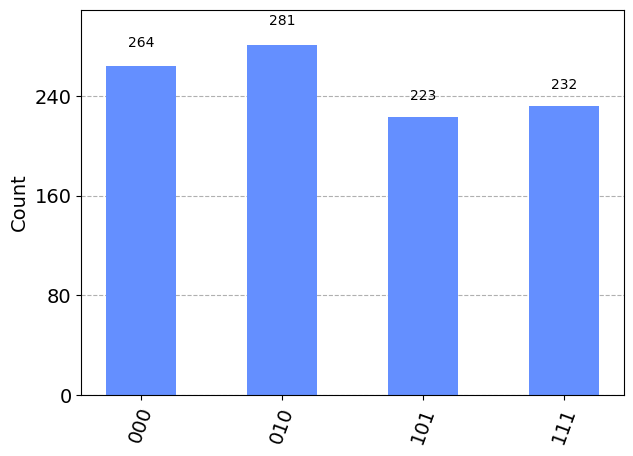

101.000 = 0 (mod 2) (25.8%)
101.111 = 0 (mod 2) (22.7%)
101.101 = 0 (mod 2) (21.8%)
101.010 = 0 (mod 2) (27.4%)


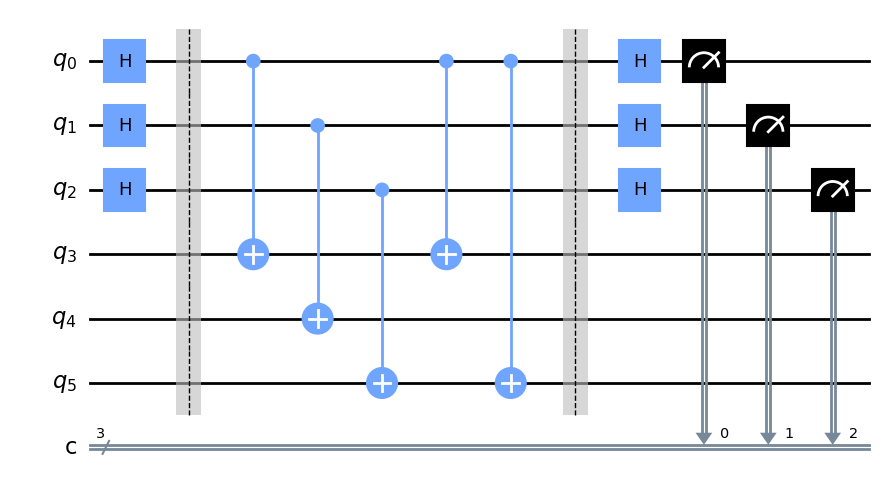

El string secreto 's' es: 101


In [2]:
if __name__ == '__main__':
    b = '101'
    simon = AlgoritmoSimon(b)
    conteos = simon.ejecutar_simulacion()
    display(plot_histogram(conteos))
    simon.revisar_resultados(conteos, 1024)
       
    simon.dibujar_circuito()

    clave_secreta_matriz_mod2 = simon.procesamiento_post_clasico(conteos)
    clave_secreta = simon.encontrar_clave_secreta(clave_secreta_matriz_mod2)

    print("El string secreto 's' es:", clave_secreta.replace("-", ""))

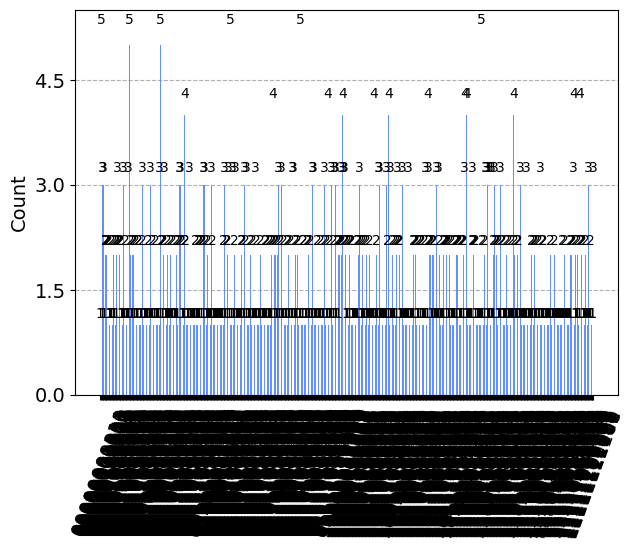

10101101101.11010001101 = 0 (mod 2) (0.2%)
10101101101.01101001110 = 0 (mod 2) (0.1%)
10101101101.00000001011 = 0 (mod 2) (0.3%)
10101101101.10010001111 = 0 (mod 2) (0.1%)
10101101101.01000001011 = 0 (mod 2) (0.1%)
10101101101.01111110001 = 0 (mod 2) (0.2%)
10101101101.11000001111 = 0 (mod 2) (0.1%)
10101101101.01110000011 = 0 (mod 2) (0.1%)
10101101101.10100111101 = 0 (mod 2) (0.2%)
10101101101.11110011001 = 0 (mod 2) (0.1%)
10101101101.11110100001 = 0 (mod 2) (0.2%)
10101101101.00001110010 = 0 (mod 2) (0.1%)
10101101101.10111011000 = 0 (mod 2) (0.2%)
10101101101.00000111111 = 0 (mod 2) (0.2%)
10101101101.01011001111 = 0 (mod 2) (0.2%)
10101101101.11010010100 = 0 (mod 2) (0.1%)
10101101101.01010110001 = 0 (mod 2) (0.1%)
10101101101.10111111001 = 0 (mod 2) (0.1%)
10101101101.00001100010 = 0 (mod 2) (0.1%)
10101101101.11010000001 = 0 (mod 2) (0.3%)
10101101101.00101011001 = 0 (mod 2) (0.1%)
10101101101.01100101011 = 0 (mod 2) (0.2%)
10101101101.11101000100 = 0 (mod 2) (0.1%)
10101101101

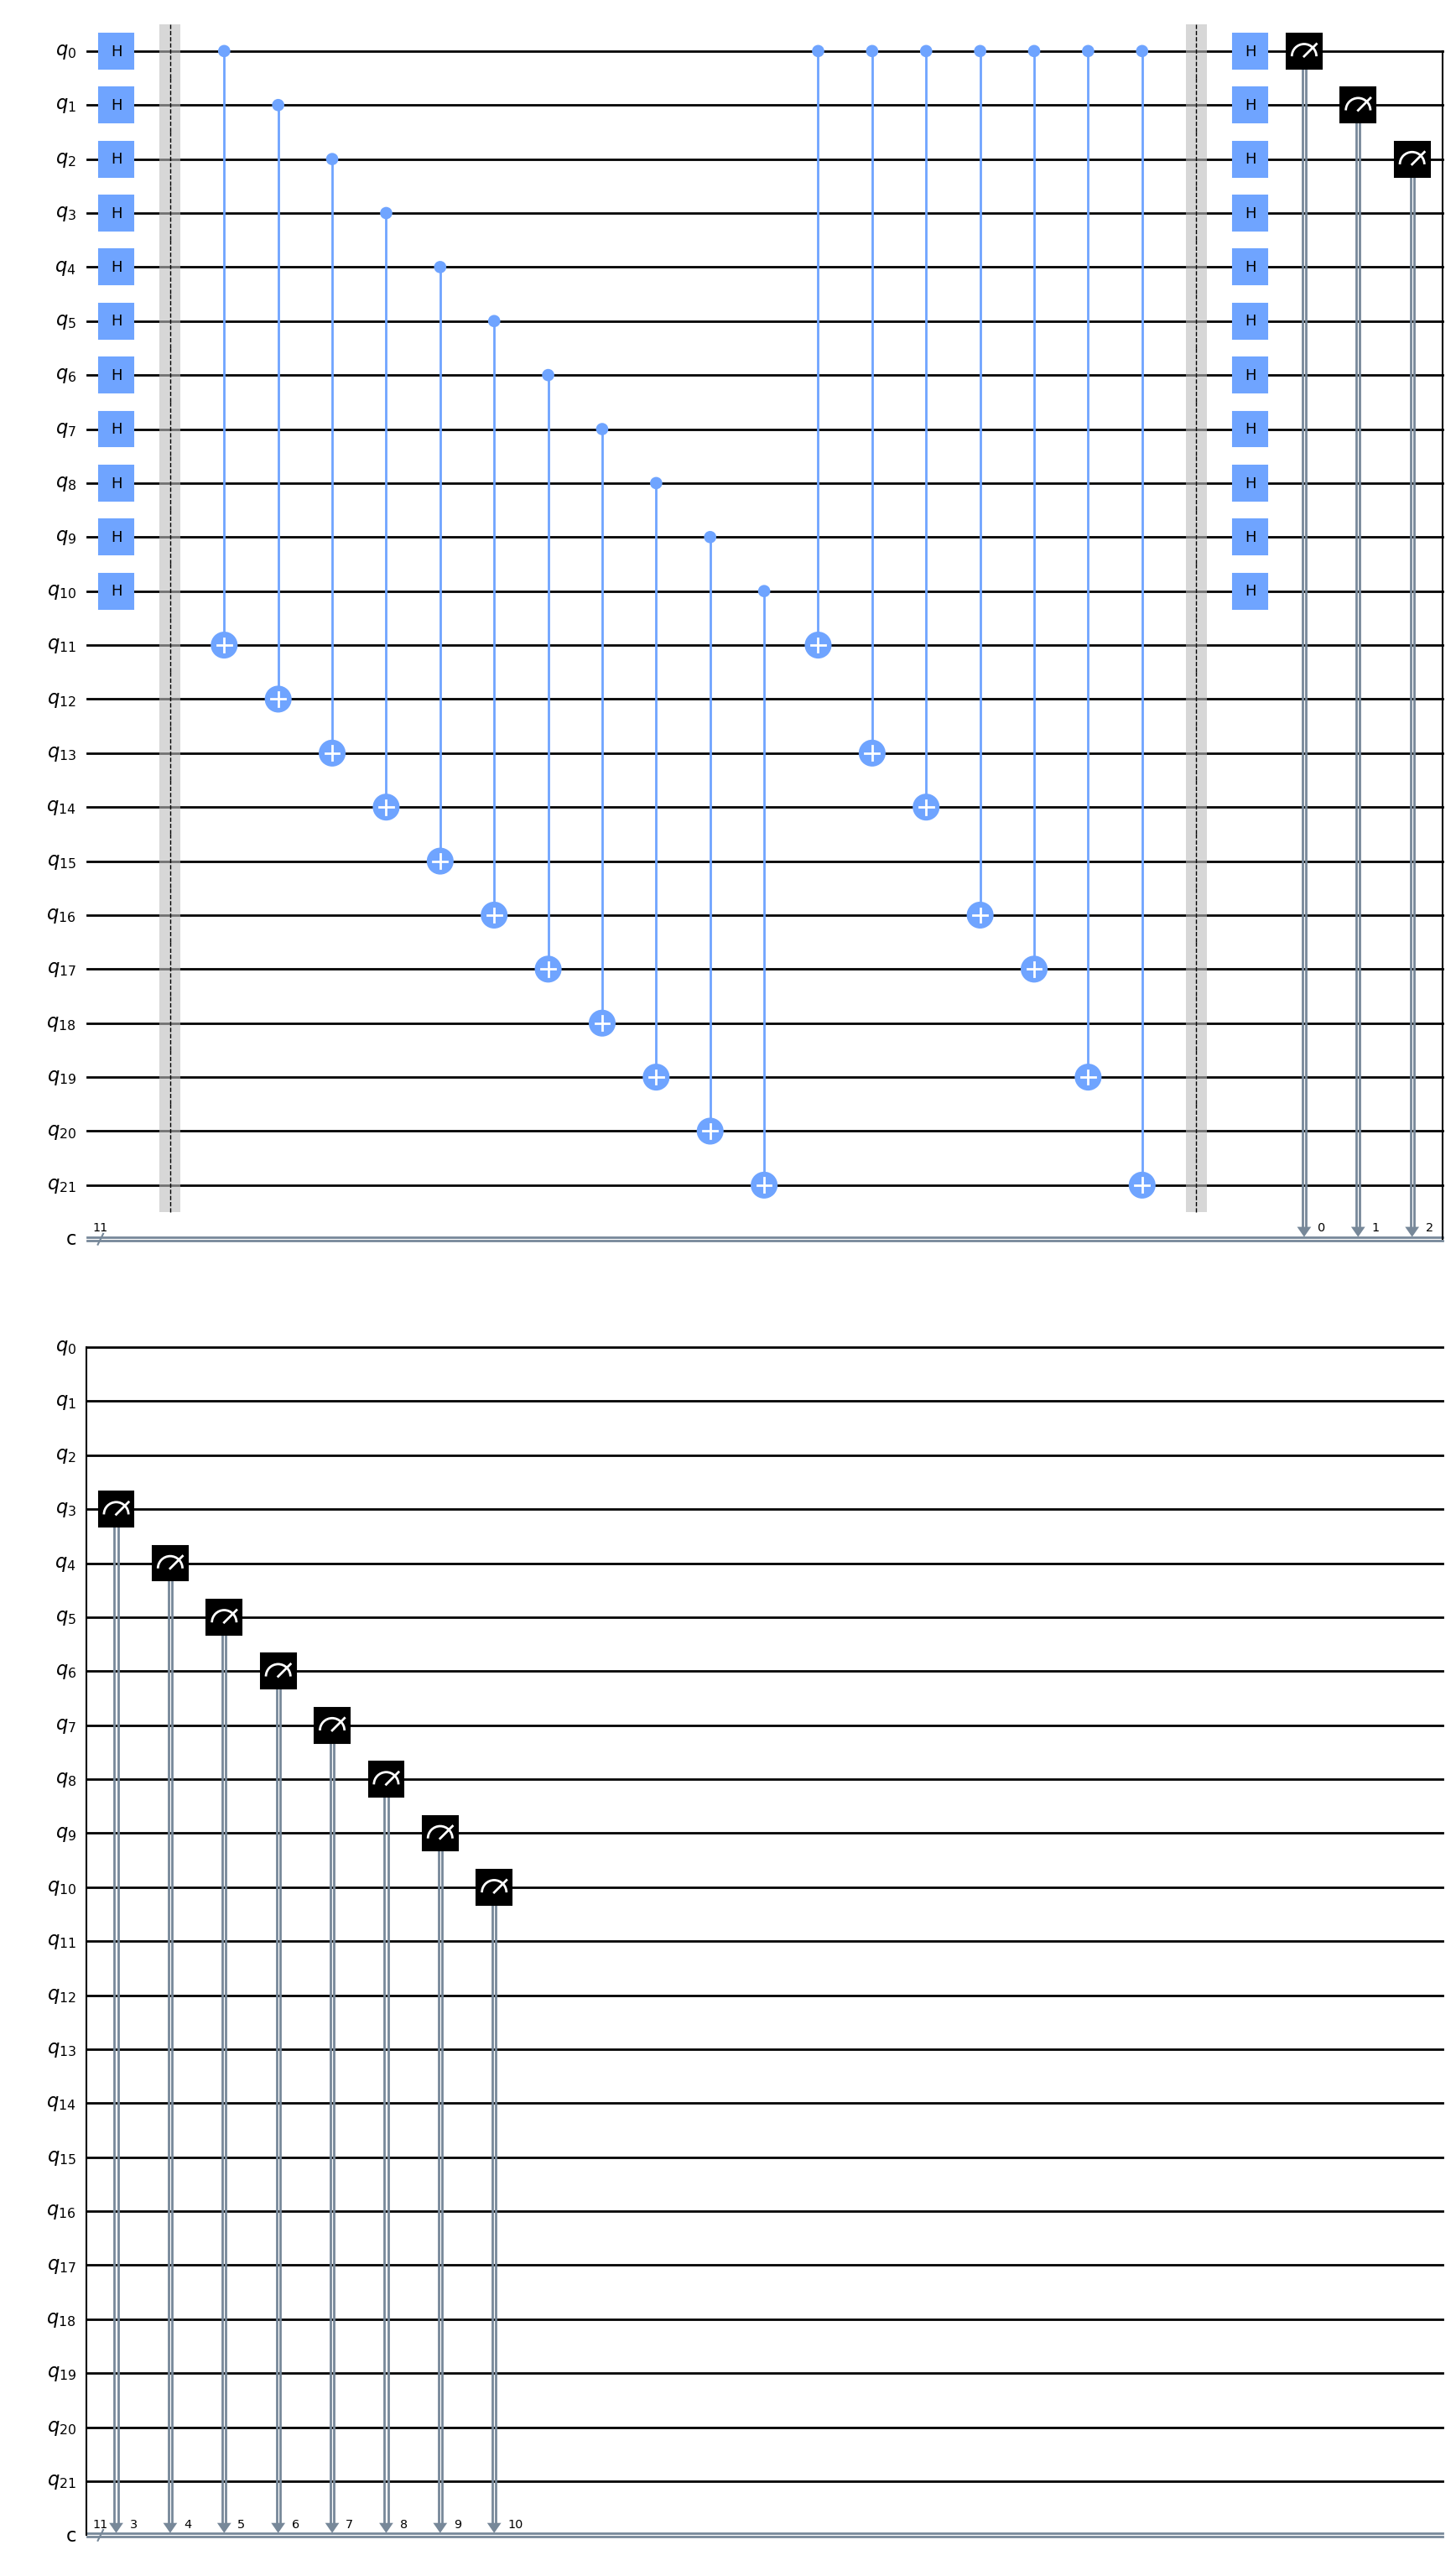

El string secreto 's' es: 10101101101


In [3]:
if __name__ == '__main__':
    b = '10101101101'
    simon = AlgoritmoSimon(b)
    conteos = simon.ejecutar_simulacion()
    display(plot_histogram(conteos))
    simon.revisar_resultados(conteos, 1024)
       
    simon.dibujar_circuito()

    clave_secreta_matriz_mod2 = simon.procesamiento_post_clasico(conteos)
    clave_secreta = simon.encontrar_clave_secreta(clave_secreta_matriz_mod2)

    print("El string secreto 's' es:", clave_secreta.replace("-", ""))